# ExxonMobil Permian Production in Texas and New Mexico

In [13]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import numpy_financial as npf

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Read data

In [14]:
DATA_DIR = Path("/Users/lindseygulden/dev/leg-up-private/permian_query_data/")

POSTPROC_TX_STATE_PRODUCTION = DATA_DIR / Path(
    "texas_rrc_district_query_postprocessed.csv"
)
POSTPROC_NM_STATE_PRODUCTION = DATA_DIR / Path("nm_ocd_c115_query_postprocessed.csv")
GREEN_BLOB_DIGITIZED = DATA_DIR / Path("green_blob_digitized.csv")
EXXON_PRESENTED_ACTUALS = DATA_DIR / Path("exxon_provided_actuals.csv")

In [15]:
# --- Read the cleaned state-regulator data for both Texas and New Mexico (see clean_data.py; detail on data source and assumptions in README.md)
tx_df = pd.read_csv(POSTPROC_TX_STATE_PRODUCTION)
nm_df = pd.read_csv(POSTPROC_NM_STATE_PRODUCTION)
# make a datetime from integer month and year
tx_df["date"] = [dt.date(y, m, 15) for y, m in zip(tx_df.year, tx_df.month)]
nm_df["date"] = [dt.date(y, m, 15) for y, m in zip(nm_df.year, nm_df.month)]

# --- Read in the digitized 'green blob' Permian production from the Q4 Earnings Call held Jan 31, 2020
blob_df = pd.read_csv(GREEN_BLOB_DIGITIZED)
blob_df.columns = ["line_label", "yr_raw", "year", "koebd"]

# --- Get 'actuals' data presented by XOM in 2020 (i.e., the digitized version of red line of slide 30 of the 2019 Q4 earnings call (held on Jan 31, 2020)
xom_actuals_df = pd.read_csv(EXXON_PRESENTED_ACTUALS)
xom_actuals_df.columns = ["line_label", "yr_raw", "year", "koebd"]


# Process data

### Process state regulators' recorded production data for each month

In [16]:
# numeric columns in texas data
cols = [
    "oil_bbl",
    "casinghead_gas_mcf",
    "gw_gas_mcf",
    "condensate_bbl",
    "casinghead_gas_boe",
    "gw_gas_boe",
    "boe",
]
groupbycols = ["state", "xto", "operator", "date"]

# For each month, sum production across RRC oil and gas districts
tx_permian_df = (
    tx_df[cols + groupbycols + ["n_days"]]
    .groupby(groupbycols)
    .agg(
        {
            "oil_bbl": "sum",
            "casinghead_gas_mcf": "sum",
            "gw_gas_mcf": "sum",
            "condensate_bbl": "sum",
            "casinghead_gas_boe": "sum",
            "gw_gas_boe": "sum",
            "boe": "sum",
            "n_days": "mean",
        }
    )
).reset_index()


tmp_df = pd.concat(
    [
        nm_df[["state", "xto", "operator", "date", "boe", "n_days"]],
        tx_permian_df[["state", "xto", "operator", "date", "boe", "n_days"]],
    ]
)
state_df = (
    tmp_df[["xto", "date", "boe", "n_days"]]
    .groupby(["xto", "date"])
    .agg({"boe": "sum", "n_days": "mean"})
).reset_index()
state_df["boe_per_day"] = state_df["boe"] / state_df["n_days"]
state_df["kboe_per_day"] = state_df["boe_per_day"] / 1000

# pivot data to short form (for easier plotting)
ocd_rrc_df = (
    state_df[["xto", "date", "kboe_per_day"]]
    .pivot(index="date", columns=["xto"])
    .reset_index()
)
ocd_rrc_df.columns = ["date", "pioneer_kboed", "xto_kboed"]
ocd_rrc_df["pioneer_plus_xto_kboed"] = (
    ocd_rrc_df["pioneer_kboed"] + ocd_rrc_df["xto_kboed"]
)

### Process digitized actuals data (as presented by XOM)

In [17]:
# Extract heritage XTO Permian actuals, as presented by XOM in the Jan 31 2020 earnings call, from the digizied plot data
xom_actuals_df = (
    xom_actuals_df[["line_label", "year", "koebd"]]
    .pivot(index="year", columns=["line_label"])
    .reset_index()
)
xom_actuals_df.columns = [
    "year",
    "bakken_plus_permian_koebd",
    "bakken_koebd",
]
xom_actuals_df["permian_actuals_kboed"] = (
    xom_actuals_df["bakken_plus_permian_koebd"] - xom_actuals_df["bakken_koebd"]
)


xom_actuals_df["date"] = [
    dt.datetime(int(np.floor(y)), 1, 1)
    + dt.timedelta(days=int(abs(y - round(y)) * 365))
    for y in xom_actuals_df.year
]

### Process the Green Blob data from the Jan 31 2020 earnings call

In [18]:
blob_df = (
    blob_df[["line_label", "year", "koebd"]]
    .pivot(index="year", columns=["line_label"])
    .reset_index()
)
blob_df.columns = ["year", "bakken_top_koebd", "permian_top_koebd"]
blob_df["permian_kboed"] = blob_df["permian_top_koebd"] - blob_df["bakken_top_koebd"]
blob_df["permian_boed"] = 1000 * blob_df["permian_kboed"]
blob_df["bakken_boed"] = 1000 * blob_df["bakken_top_koebd"]
blob_df.rename(
    columns={
        "permian_top_koebd": "permian_plot_top_koebd",
    },
    inplace=True,
)

blob_df["date"] = [
    dt.datetime(int(np.floor(y)), 1, 1)
    + dt.timedelta(days=int(abs(y - round(y)) * 365))
    for y in blob_df.year
]

# Figure

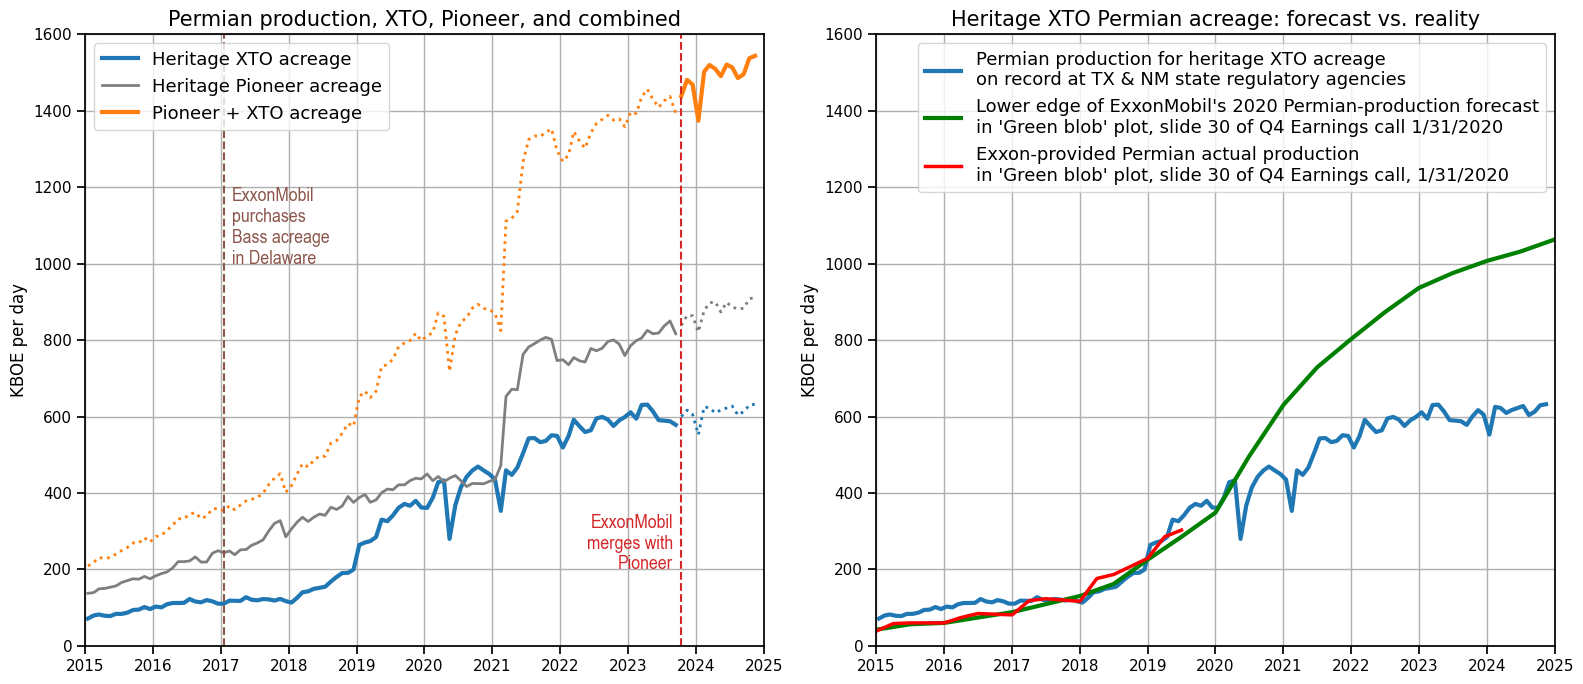

In [19]:
sns.set_context("notebook")

# get tick locations and labels for horizontal axis
date_list = []
date_labels = []
for y in range(2015, 2026):
    date_list.append(dt.date(y, 1, 1))
    date_labels.append(y)

# various sizes
legend_fontsize = 13
title_fontsize = 15
y_axis_lim = 1.6e3

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
ax = axes[0]
sns.lineplot(
    data=ocd_rrc_df.loc[ocd_rrc_df.date < dt.date(2023, 10, 13)],
    x="date",
    y="xto_kboed",
    color="tab:blue",
    lw=3,
    ax=ax,
    label="Heritage XTO acreage",
)
sns.lineplot(
    data=ocd_rrc_df.loc[ocd_rrc_df.date >= dt.date(2023, 10, 13)],
    x="date",
    y="xto_kboed",
    color="tab:blue",
    linewidth=2,
    linestyle=":",
    ax=ax,
)
sns.lineplot(
    data=ocd_rrc_df.loc[ocd_rrc_df.date < dt.date(2023, 10, 13)],
    x="date",
    y="pioneer_kboed",
    color="tab:grey",
    ax=ax,
    linewidth=2,
    label="Heritage Pioneer acreage",
)
sns.lineplot(
    data=ocd_rrc_df.loc[ocd_rrc_df.date >= dt.date(2023, 10, 13)],
    x="date",
    y="pioneer_kboed",
    linestyle=":",
    linewidth=2,
    color="tab:grey",
    ax=ax,
)
sns.lineplot(
    data=ocd_rrc_df.loc[ocd_rrc_df.date < dt.date(2023, 10, 13)],
    x="date",
    y="pioneer_plus_xto_kboed",
    linestyle=":",
    linewidth=2,
    color="tab:orange",
    ax=ax,
)
sns.lineplot(
    data=ocd_rrc_df.loc[ocd_rrc_df.date >= dt.date(2023, 10, 13)],
    x="date",
    y="pioneer_plus_xto_kboed",
    color="tab:orange",
    lw=3,
    ax=ax,
    label="Pioneer + XTO acreage",
)
ax.plot(
    [dt.date(2023, 10, 13), dt.date(2023, 10, 13)],
    [0, y_axis_lim],
    ls="--",
    color="tab:red",
)
ax.text(
    dt.date(2023, 9, 1),
    200,
    "ExxonMobil\nmerges with\nPioneer",
    font="Arial Narrow",
    fontsize=14,
    color="tab:red",
    horizontalalignment="right",
)
ax.plot(
    [dt.date(2017, 1, 17), dt.date(2017, 1, 17)],
    [0, y_axis_lim],
    ls="--",
    color="tab:brown",
)
ax.text(
    dt.date(2017, 3, 1),
    1000,
    "ExxonMobil\npurchases\nBass acreage\nin Delaware",
    font="Arial Narrow",
    fontsize=14,
    color="tab:brown",
    horizontalalignment="left",
)

ax.grid()
ax.set_xticks(date_list)
ax.set_xticklabels(date_labels)
ax.set_xlim([date_list[0], date_list[-1]])
ax.set_ylim([0, y_axis_lim])
ax.set_ylabel("KBOE per day")
ax.set_xlabel("")
ax.legend(fontsize=legend_fontsize)
ax.set_title("Permian production, XTO, Pioneer, and combined", fontsize=title_fontsize)
ax = axes[1]
sns.lineplot(
    data=ocd_rrc_df,
    x="date",
    y="xto_kboed",
    linewidth=3,
    ax=ax,
    label="Permian production for heritage XTO acreage\non record at TX & NM state regulatory agencies",
)
sns.lineplot(
    data=blob_df,
    x="date",
    y="permian_kboed",
    color="g",
    linewidth=3,
    ax=ax,
    label="Lower edge of ExxonMobil's 2020 Permian-production forecast\nin 'Green blob' plot, slide 30 of Q4 Earnings call 1/31/2020",
)

sns.lineplot(
    data=xom_actuals_df,
    x="date",
    y="permian_actuals_kboed",
    color="r",
    linestyle="-",
    lw=2.5,
    label="Exxon-provided Permian actual production\nin 'Green blob' plot, slide 30 of Q4 Earnings call, 1/31/2020",
)
ax.grid()
ax.set_xticks(date_list)
ax.set_xticklabels(date_labels)
ax.set_xlim([date_list[0], date_list[-1]])
ax.set_ylim([0, y_axis_lim])
ax.set_ylabel("KBOE per day")
ax.set_xlabel("")
ax.legend(fontsize=legend_fontsize)
ax.set_title(
    "Heritage XTO Permian acreage: forecast vs. reality", fontsize=title_fontsize
)
fig.tight_layout()
fig.savefig(fname="green_blob_vs_reality.png", format="png")

# Quantify the value of the discrepancy between forecast and actuals

In [20]:
# Put heritage-XTO-acreage production and green blob forecast together in single dataframe

xto_df = ocd_rrc_df[["date", "xto_kboed"]]
xto_df["date"] = [dt.datetime(d.year, d.month, 1) for d in xto_df.date]
blob_vs_real_df = xto_df.merge(
    blob_df[["date", "permian_kboed"]], left_on="date", right_on="date", how="left"
)
blob_vs_real_df["permian_kboed"] = blob_vs_real_df["permian_kboed"].interpolate(
    method="cubicspline"
)
blob_vs_real_df.columns = ["date", "actual_kboed", "projected_kboed"]
blob_vs_real_df["diff_kboed"] = (
    blob_vs_real_df["projected_kboed"] - blob_vs_real_df["actual_kboed"]
)

In [21]:
# Construct a hypothetical aggressive 'catch up' case, in which ExxonMobil accelerates production to catch up to its 1m boed
n_years = 4
hypothetical_catchup_diff_kboed = np.linspace(418.717674, 0, n_years)

hypothetical_catchup = {
    "date": [dt.datetime(x, 1, 1) for x in range(2025, 2025 + n_years)],
    "actual_kboed": [1050.8 - d for d in hypothetical_catchup_diff_kboed],
    "projected_kboed": [1050.8] * n_years,
    "diff_kboed": hypothetical_catchup_diff_kboed,
}

# Merge the hypothetical case with the integrated Blob/real data
hypothetical_production_df = pd.concat(
    [pd.DataFrame(hypothetical_catchup), blob_vs_real_df]
)

In [25]:
# sort production dataframe in ascending order of date
hypothetical_production_df.sort_values(by="date", ascending=True, inplace=True)
# compute number of days in period (for NPV calcs)
hypothetical_production_df["date_shift"] = hypothetical_production_df.date.shift(
    1, fill_value=dt.datetime(2014, 12, 1)
)
hypothetical_production_df["days_in_period"] = [
    (d - s).days
    for s, d in zip(
        hypothetical_production_df["date_shift"], hypothetical_production_df["date"]
    )
]
# convert from kboed to boe, multiplying by the number of days in the given row's time period and 1000 (1000 barrels in 1 kilo-barrel)
hypothetical_production_df["diff_boe"] = (
    hypothetical_production_df["diff_kboed"]
    * hypothetical_production_df["days_in_period"]
    * 1000
)

# find the total boe difference between the blob and the reality/hypothetical extension of reality
boe_diff_yearly_total = list(
    hypothetical_production_df[["date", "diff_boe"]]
    .loc[hypothetical_production_df.date > dt.datetime(2019, 12, 31)]
    .groupby(pd.Grouper(key="date", freq="1Y"))
    .sum()["diff_boe"]
)
print(
    f"The total volume difference between the Green Blob and the reality/hypothetical extension is {np.sum(boe_diff_yearly_total):.0f} BOE."
)

The total volume difference between the Green Blob and the reality/hypothetical extension is 665773356 BOE.


## Report NPV of discrepancy between 2020 public forecast and actuals

In [27]:
## Compute the NPV of the difference between the blob and real production + hypothetical extension
discount_rate = 0.08
profit_per_boe_usd = 20
npv_of_difference = npf.npv(
    discount_rate, [profit_per_boe_usd * x for x in boe_diff_yearly_total]
)

print(
    f"Assuming a discount rate of {discount_rate*100:.0f}% and a profit of ${profit_per_boe_usd:.0f}/BOE,\nthe NPV of the difference between production and actuals is ${npv_of_difference/1e9:.1f} billion."
)

Assuming a discount rate of 8% and a profit of $20/BOE,
the NPV of the difference between production and actuals is $10.3 billion.


# Figure showing value of discrepancy
Plot the time series in the hypothetical 'aggressive catch up' case; report NPV using standard financial assumptions.

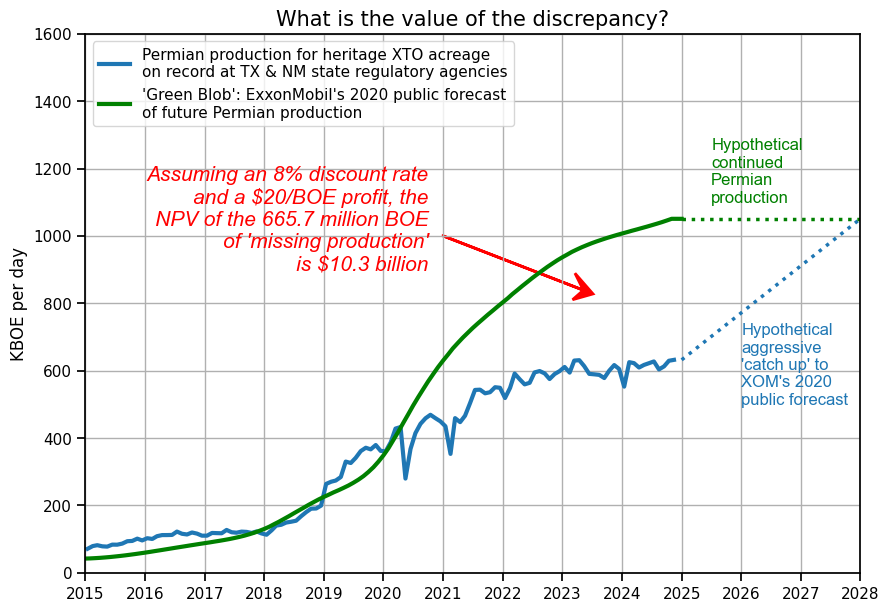

In [29]:
sns.set_context("notebook")

# get tick locations and labels for horizontal axis
date_list = []
date_labels = []
for y in range(2015, 2025 + n_years):
    date_list.append(dt.date(y, 1, 1))
    date_labels.append(y)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.lineplot(
    data=ocd_rrc_df,
    x="date",
    y="xto_kboed",
    linewidth=3,
    ax=ax,
    label="Permian production for heritage XTO acreage\non record at TX & NM state regulatory agencies",
)
sns.lineplot(
    data=hypothetical_production_df.loc[
        hypothetical_production_df.date >= dt.datetime(2024, 12, 1)
    ],
    x="date",
    y="actual_kboed",
    linewidth=2.5,
    linestyle=":",
    ax=ax,
    color="tab:blue",
)
sns.lineplot(
    data=hypothetical_production_df.loc[
        hypothetical_production_df.date <= dt.datetime(2025, 1, 1)
    ],
    x="date",
    y="projected_kboed",
    color="g",
    linewidth=3,
    ax=ax,
    label="'Green Blob': ExxonMobil's 2020 public forecast\nof future Permian production",
)
sns.lineplot(
    data=hypothetical_production_df.loc[
        hypothetical_production_df.date >= dt.datetime(2025, 1, 1)
    ],
    x="date",
    y="projected_kboed",
    color="g",
    linewidth=2.5,
    linestyle=":",
    ax=ax,
    # label="Lower edge of ExxonMobil's 2020 Permian-production forecast\nin 'Green blob' plot, slide 30 of Q4 Earnings call 1/31/2020",
)
ax.text(
    dt.date(2026, 1, 1),
    500,
    "Hypothetical\naggressive\n'catch up' to \nXOM's 2020\npublic forecast",
    font="Arial",
    fontsize=12,
    color="tab:blue",
    horizontalalignment="left",
)
ax.text(
    dt.date(2025, 7, 1),
    1100,
    "Hypothetical\ncontinued\nPermian\nproduction",
    font="Arial",
    fontsize=12,
    color="g",
    horizontalalignment="left",
)
ax.arrow(
    dt.datetime(2021, 1, 1),
    1000,
    800,
    -150,
    lw=2,
    head_width=80,
    overhang=0.5,
    color="r",
)
ax.text(
    dt.date(2020, 10, 1),
    900,
    "Assuming an 8% discount rate\nand a $20/BOE profit, the\nNPV of the 665.7 million BOE\nof 'missing production'\nis $10.3 billion",
    font="Arial",
    fontsize=15,
    fontstyle="oblique",
    color="r",
    horizontalalignment="right",
)
ax.grid()
ax.set_xticks(date_list)
ax.set_xticklabels(date_labels)
ax.set_xlim([date_list[0], date_list[-1]])
ax.set_ylim([0, y_axis_lim])
ax.set_ylabel("KBOE per day")
ax.set_xlabel("")
ax.legend(fontsize=11, loc="upper left")
ax.set_title("What is the value of the discrepancy?", fontsize=title_fontsize)
fig.savefig("what_is_the_npv_of_the_discrepancy.png")